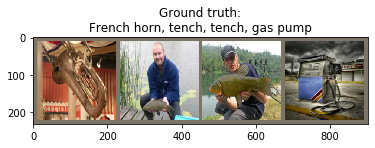

In [4]:
from __future__ import division, print_function

import copy
import os
import time
import urllib
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
from tqdm.notebook import tqdm


def import_dataset(dataset_path):
  """
  Retrieve training and testing dataset: ImageNette

  10 class_names: [tench, English springer, cassette player, chain saw,
    church, French horn, garbage truck, gas pump, golf ball, parachute]

  size: 160px * 160px
  """
  transform = transforms.Compose([
      transforms.Resize((213, 213)),
      transforms.ToTensor(),
      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
  ])

  image_datasets = {x: torchvision.datasets.ImageFolder(root=os.path.join(
      dataset_path, x), transform=transform) for x in ['train', 'val']}
  data_loaders = {x: torch.utils.data.DataLoader(
      image_datasets[x], batch_size=4, shuffle=True, num_workers=0) for x in ['train', 'val']}
  data_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

  return data_loaders, data_sizes


def preview_images(img, img_title=None):
  """
  Preview images with normal values (denormalized)
  """
  img = img.numpy().transpose((1, 2, 0))
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  img = std * img + mean
  img = np.clip(img, 0, 1)
  plt.imshow(img)
  if img_title is not None:
    plt.title('Ground truth:\n{}'.format(', '.join(img_title)))
  plt.pause(0.001)


def notify_server_chan(msg_title, msg_desp):
  """
  Notify training complete with Server Chan
  """
  msg_title = urllib.parse.quote_plus(msg_title)
  msg_desp = urllib.parse.quote_plus(msg_desp)
  url = 'https://sc.ftqq.com/SCU51420Tc53c54655f0a9ffe3d66789be07a51af5cda6de0e572a.send?text={}&desp={}'.format(
      msg_title, msg_desp)

  f = urllib.request.urlopen(url)
  print('\n[Server Chan]', f.read().decode('utf-8'))


def train_model(device, data_loaders, data_sizes, model, criterion, optimizer, scheduler, epoches=25):
  """
  Train model ResNet18 with ImageNette dataset
  """
  tic = time.time()

  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0

  loss_list = {'train': [], 'val': []}
  acc_list = {'train': [], 'val': []}

  for epoch in range(epoches):
    # begin epoch

    for phase in ['train', 'val']:
      if phase == 'train':
        model.train()
      else:
        model.eval()

      running_loss = 0.0
      running_corrects = 0

      pbar = tqdm(data_loaders[phase])
      pbar.set_description(
          'Epoch: {}/{} - {:>5}'.format(epoch + 1, epoches, phase))
      pbar.set_postfix(loss='')

      # iterate over data
      for images, labels in pbar:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        # forward propaganda
        with torch.set_grad_enabled(phase == 'train'):
          outputs = model(images)
          _, preds = torch.max(outputs, 1)
          loss = criterion(outputs, labels)

          # backward propaganda only in training mode
          if phase == 'train':
            loss.backward()
            optimizer.step()

        # statistics
        running_loss += loss.item() * images.size(0)
        running_corrects += torch.sum(preds == labels.data)

        # update progress
        pbar.set_postfix(loss='{:.2f}%'.format(
            loss.detach().cpu().numpy()))

      if phase == 'train':
        scheduler.step()

      epoch_loss = running_loss / data_sizes[phase]
      epoch_acc = running_corrects.double() / data_sizes[phase]

      # TODO: Fix progress bar faulty output
      # pbar.write('[{}] Loss: {:.2f}% Acc: {:.2f}%'.format(
      #     phase, epoch_loss, epoch_acc))

      # save loss / acc for plotting
      loss_list[phase].append(epoch_loss)
      acc_list[phase].append(epoch_acc)

      # deepcopy the model
      if phase == 'val' and epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model_wts = copy.deepcopy(model.state_dict())

    # epoch done
    # tqdm.write('')

  # total training time
  toc = time.time()
  time_elapsed = toc - tic

  # print statistics
  print('\nTraining completed in {:.0f}m {:.0f}s'.format(
      time_elapsed // 60, time_elapsed % 60))
  print('Best validation accuracy: {:4f} %'.format(best_acc * 100))

  # send notifications
  msg_title = 'Congrats, training success!'
  msg_desp = '**Training completed in** `{:.0f}m {:.0f}s`\n**Best validation accuracy:** `{:4f} %`'.format(
      time_elapsed // 60, time_elapsed % 60, best_acc * 100)
  try:
    notify_server_chan(msg_title, msg_desp)
  except Exception as e:
    print(e)

  model.load_state_dict(best_model_wts)
  return model, loss_list, acc_list


if __name__ == "__main__":
  # utilize gpu
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

  # define class names
  class_names = ['tench', 'English springer', 'cassette player', 'chain saw', 'church',
                 'French horn', 'garbage truck', 'gas pump', 'golf ball', 'parachute']

  # path to dataset
  dataset_path = '../data/imagenette2-160'
  data_loaders, data_sizes = import_dataset(dataset_path)

  # preview images from training set
  inputs, labels = next(iter(data_loaders['train']))
  out = torchvision.utils.make_grid(inputs, padding=10)
  preview_images(out, img_title=[class_names[x] for x in labels])


In [5]:
  # Train ResNet18 as a fixed feature extractor
  # See here: https://cs231n.github.io/transfer-learning/
  #   for different types of ways to performing transfer learning
  print('Preparing ConvNET...')

  # instantiate ResNet18 model with pretrained weights from ImageNet
  model_conv = torchvision.models.resnet18(pretrained=True)

  # freeze all layers except the final layer (dense layer)
  for param in model_conv.parameters():
    param.requires_grad = False

  # create final feature extraction linear layer
  num_features = model_conv.fc.in_features
  model_conv.fc = nn.Linear(num_features, len(class_names))

  # push model to GPU
  model_conv = model_conv.to(device)

  # define criterion, optimizer and scheduler
  criterion = nn.CrossEntropyLoss()
  optimizer_conv = optim.SGD(
      model_conv.fc.parameters(), lr=0.001, momentum=0.9)
  exp_lr_scheduler = lr_scheduler.StepLR(
      optimizer=optimizer_conv, step_size=7, gamma=0.1)


Preparing ConvNET...


In [ ]:
  # Train and evaluate model
  # 8 epoches roughly takes an hour of training and evaluation or less on GPU,
  #   with an accuracy of around 97%
  model_epoches = 8
  model_conv, loss, acc = train_model(device, data_loaders, data_sizes, model_conv,
                                      criterion, optimizer_conv, exp_lr_scheduler, epoches=model_epoches)

  # save trained model
  now = datetime.now()
  MODEL_PATH = '{}_resnet_imagenette.pth'.format(now.strftime('%y%m%d_%H%M'))
  torch.save(model_conv.state_dict(), MODEL_PATH)

  # plot loss and acc
  x = np.arange(0, model_epoches)

  plt.figure(figsize=(12, 6))
  plt.subplot(121)
  plt.plot(x, loss['train'], label='train loss')
  plt.plot(x, acc['train'], label='train accuracy')
  plt.title('Training statistics')
  plt.legend()

  plt.subplot(122)
  plt.plot(x, loss['val'], label='validate loss')
  plt.plot(x, acc['val'], label='validate accuracy')
  plt.title('Validation statistics')
  plt.legend()
  plt.show()

